# Analyse de la performance d’une stratégie GARP (Growth at a Reasonable Price)

**Master 2 Finance Internationale**

Objectif :
Analyser la performance d’une stratégie de conviction GARP, en décomposant l’alpha,
et en évaluant la persistance du couple rendement–risque face à des benchmarks mondiaux.


In [1]:
# =========================
# INSTALLATION DES PACKAGES
# =========================

! pip install pandas numpy yfinance matplotlib seaborn statsmodels openpyxl scikit-learn


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 76.0 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 83.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 77.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 76.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 75.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 80.1 MB/s  0:00:006m0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15635 sha256=7

## 1. Préparation des données - Portefeuille GARP

Cette section vise à importer, nettoyer et harmoniser les données nécessaires à l’analyse empirique :
- Actions du portefeuille GARP (Yahoo Finance)
- Devise homogène : EUR
- Fréquence : mensuelle


In [2]:
# ======================================================
# 1. PREPARATION DES DONNEES – PORTEFEUILLE GARP
# ======================================================

# ----------------------
# 1.1 Librairies
# ----------------------
import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path


# ----------------------
# 1.2 Univers d’investissement
# ----------------------
# Portefeuille GARP composé de 10 actions internationales
# La devise associée à chaque titre est précisée afin de
# permettre une conversion rigoureuse en euros

garp_stocks = {
    "ADYEN.AS": "EUR",
    "KRI.AT": "EUR",
    "AMZN": "USD",
    "META": "USD",
    "GOOGL": "USD",
    "CSU.TO": "CAD",
    "MELI": "USD",
    "DNP.WA": "PLN",
    "NU": "USD",
    "KNSL": "USD"
}


# ----------------------
# 1.3 Période d’étude
# ----------------------
start_date = "2021-02-01"
end_date = "2026-01-31"


# ----------------------
# 1.4 Téléchargement des prix ajustés
# ----------------------
# Les prix ajustés (auto_adjust=True) incluent les dividendes
# et sont extraits depuis Yahoo Finance

prices = yf.download(
    tickers=list(garp_stocks.keys()),
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]


# ----------------------
# 1.5 Passage en fréquence mensuelle
# ----------------------
# Les prix sont retenus en fin de mois afin d’être cohérents
# avec les benchmarks utilisés dans l’analyse ultérieure

prices_m = prices.resample("ME").last()


# ----------------------
# 1.6 Conversion des prix en euros
# ----------------------

# Tickers de change Yahoo Finance (devise locale -> EUR)
fx_tickers = {
    "USD": "USDEUR=X",
    "CAD": "CADEUR=X",
    "PLN": "PLNEUR=X"
}

# Téléchargement des taux de change
fx = yf.download(
    tickers=list(fx_tickers.values()),
    start=start_date,
    auto_adjust=True,
    progress=False
)["Close"]

# Passage en fréquence mensuelle
fx = fx.resample("ME").last()
fx.columns = fx_tickers.keys()

# Conversion des prix non libellés en EUR
prices_eur = prices_m.copy()

for ticker, currency in garp_stocks.items():
    if currency != "EUR":
        prices_eur[ticker] = prices_m[ticker] * fx[currency]


# ----------------------
# 1.7 Calcul des rendements logarithmiques
# ----------------------
# Les rendements logarithmiques sont privilégiés pour leur
# additivité temporelle et leur usage standard en finance empirique

returns_stocks = np.log(prices_eur / prices_eur.shift(1)).dropna()

# ----------------------
# 1.7 bis Traitement des valeurs manquantes
# ----------------------
# Les valeurs manquantes éventuelles sont remplacées par la
# médiane de chaque série afin de limiter l’impact des outliers
# et de préserver la structure de distribution des rendements

returns_stocks = returns_stocks.apply(
    lambda x: x.fillna(x.median())
)


# ----------------------
# 1.8 Construction du portefeuille GARP équipondéré
# ----------------------
# Chaque actif reçoit un poids constant identique

n_assets = returns_stocks.shape[1]
weights = np.repeat(1 / n_assets, n_assets)

# Rendement mensuel du portefeuille GARP
garp_portfolio_returns = returns_stocks.dot(weights)
garp_portfolio_returns.name = "GARP_Portfolio"


# ----------------------
# 1.9 Sauvegarde des données
# ----------------------
DATA_PROCESSED = Path("../data/processed")
DATA_PROCESSED.mkdir(exist_ok=True)

returns_stocks.to_csv(DATA_PROCESSED / "garp_stocks_returns.csv")
garp_portfolio_returns.to_csv(DATA_PROCESSED / "garp_portfolio_returns.csv")


## 2. Analyse descriptive & performance globale — Portefeuille GARP vs MSCI World

Cette section vise à répondre à l’hypothèse H1 — la surperformance du portefeuille GARP comparée au benchmark MSCI World, en termes de rendement ajusté du risque.

Les étapes réalisées sont :
- Calcul des performances cumulées des deux séries de rendements mensuels.
- Calcul des indicateurs annuels : rendement annualisé, volatilité annualisée, ratio rendement/risque (Sharpe).
- Analyse des drawdowns (pertes relatives maximales).
- Visualisation graphique des performances cumulées et des drawdowns.
- Export des graphiques et des tableaux de résultats dans les dossiers dédiés.

### Analyses descriptives enrichies – Portefeuille GARP vs MSCI World

Nous complétons l'analyse initiale avec les éléments suivants :

- Histogrammes et boxplots des rendements mensuels (distribution et asymétrie)
- Rolling volatility et rolling Sharpe pour visualiser la stabilité du risque
- Analyse de corrélation entre GARP et MSCI World
- Calcul de Skewness et Kurtosis pour apprécier le profil de risque tail
- Metrics de downside risk : Sortino ratio, VaR, CVaR
- Table de performance cumulée sur différents horizons : 1, 3, 5 ans

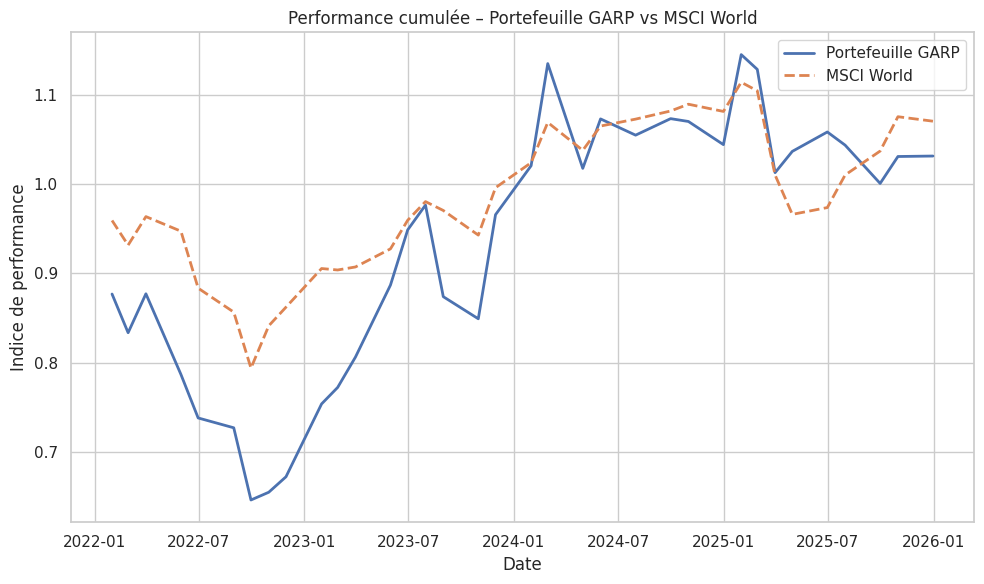

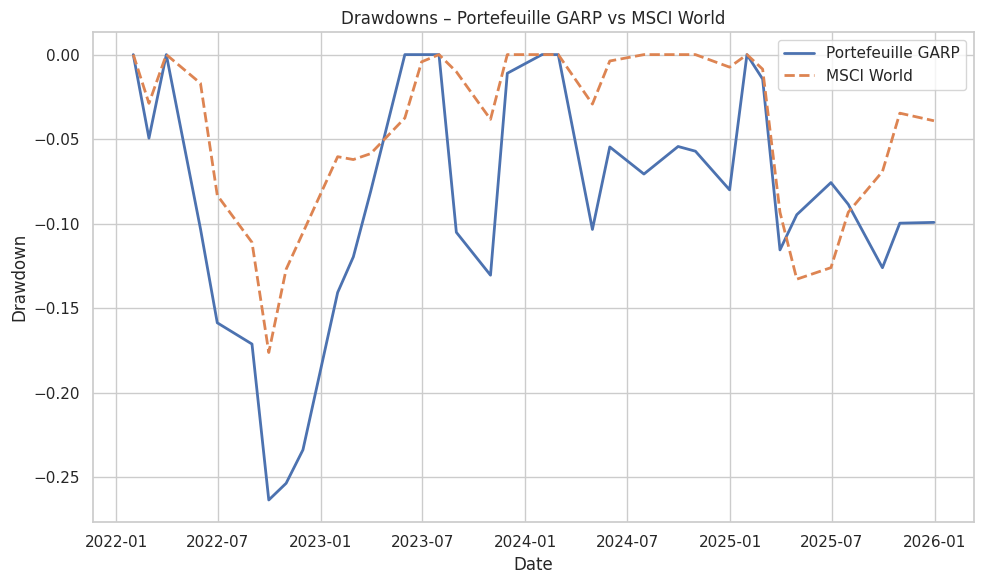

            Rendement annualisé  Volatilité annualisée  Ratio de Sharpe  \
GARP                   0.039374               0.242298         0.162501   
MSCI_World             0.031432               0.127192         0.247120   

            Drawdown maximum  
GARP               -0.263587  
MSCI_World         -0.176313  
=== Statistiques enrichies ===
            Rendement annualisé  Volatilité annualisée    Sharpe  Skewness  \
GARP                   0.039374               0.242298  0.162501 -0.097175   
MSCI_World             0.031432               0.127192  0.247120 -0.646791   

            Kurtosis   Sortino    VaR_95   CVaR_95  
GARP       -0.569946  0.236604 -0.107027 -0.117208  
MSCI_World -0.112515  0.341223 -0.069202 -0.079404  

=== Matrice de corrélation ===
                GARP  MSCI_World
GARP        1.000000    0.764111
MSCI_World  0.764111    1.000000


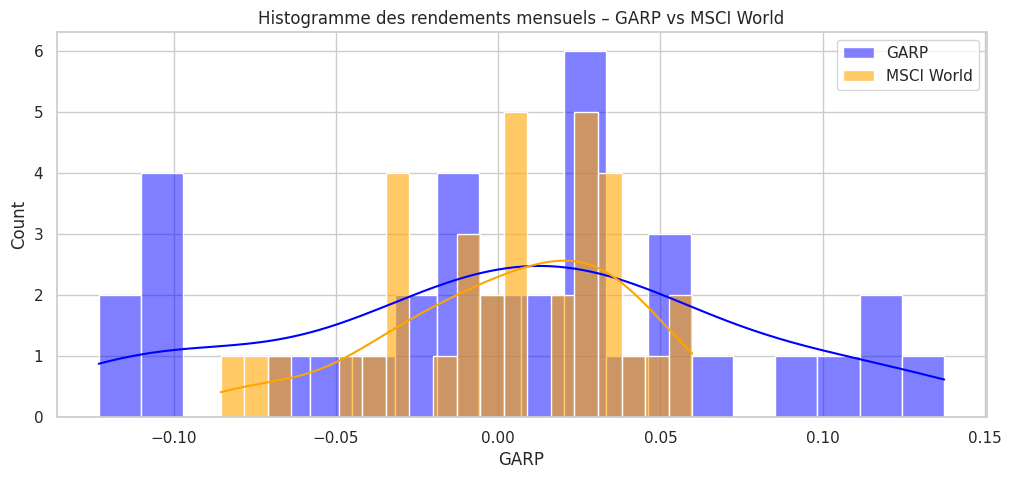

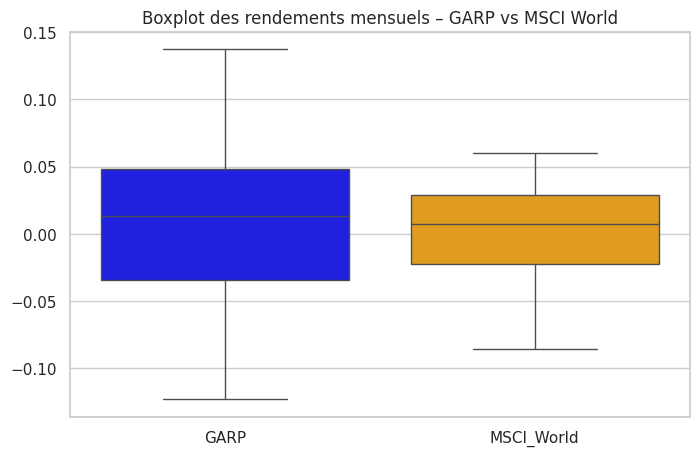

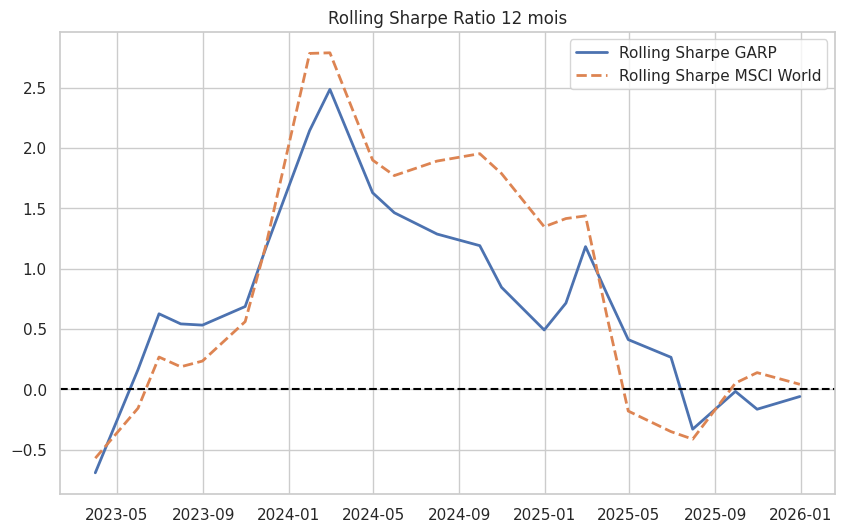


=== Performance cumulée sur 1, 3, 5 ans ===
                  1Y  3Y  5Y
GARP       -0.022189 NaN NaN
MSCI_World -0.002160 NaN NaN
=== Toutes les figures et tables enrichies ont été sauvegardées dans results/figures et results/tables ===


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

sns.set_theme(style="whitegrid")

# Définition des chemins
DATA_RAW = Path("../data/raw")
RESULTS_FIGURES = Path("../results/figures")
RESULTS_TABLES = Path("../results/tables")
RESULTS_FIGURES.mkdir(parents=True, exist_ok=True)
RESULTS_TABLES.mkdir(parents=True, exist_ok=True)

# --- Import MSCI World (FactSet), données mensuelles déjà en EUR ---
msci_world = pd.read_excel(DATA_RAW / "msci_world_factset.xlsx")

# Conversion et préparation des données MSCI World
msci_world.iloc[:, 0] = pd.to_datetime(msci_world.iloc[:, 0])
msci_world.set_index(msci_world.columns[0], inplace=True)
msci_world = msci_world.sort_index()
msci_world = msci_world.iloc[:, 0]
msci_world.name = "MSCI_World"

# Calcul des rendements logarithmiques mensuels MSCI World
r_msci_world = np.log(msci_world / msci_world.shift(1))

# Alignement temporel avec le portefeuille GARP (déjà chargé en mémoire)
returns_comp = pd.concat([garp_portfolio_returns, r_msci_world], axis=1, sort=False).dropna()
returns_comp.columns = ["GARP", "MSCI_World"]

# --- Calcul de la performance cumulée ---
cumulative_perf = (1 + returns_comp).cumprod()

# Graphique des performances cumulées
plt.figure(figsize=(10, 6))
plt.plot(cumulative_perf["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(cumulative_perf["MSCI_World"], label="MSCI World", linestyle="--", linewidth=2)
plt.title("Performance cumulée – Portefeuille GARP vs MSCI World")
plt.xlabel("Date")
plt.ylabel("Indice de performance")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "performance_cumulee_garp_vs_msci_world.png")
plt.show()

# --- Calcul des drawdowns ---
rolling_max = cumulative_perf.cummax()
drawdown = cumulative_perf / rolling_max - 1

# Graphique des drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(drawdown["MSCI_World"], label="MSCI World", linestyle="--", linewidth=2)
plt.title("Drawdowns – Portefeuille GARP vs MSCI World")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "drawdowns_garp_vs_msci_world.png")
plt.show()

# --- Calcul des indicateurs de performance ---
perf_stats = pd.DataFrame(index=["GARP", "MSCI_World"])
perf_stats["Rendement annualisé"] = returns_comp.mean() * 12
perf_stats["Volatilité annualisée"] = returns_comp.std() * np.sqrt(12)
perf_stats["Ratio de Sharpe"] = (
    perf_stats["Rendement annualisé"] / perf_stats["Volatilité annualisée"]
)
perf_stats["Drawdown maximum"] = drawdown.min()

# Affichage des statistiques
print(perf_stats)

# Sauvegarde des statistiques au format CSV
perf_stats.to_csv(RESULTS_TABLES / "performance_stats_garp_vs_msci_world.csv")

# --- Variables existantes déjà en mémoire ---
# returns_comp = pd.concat([garp_portfolio_returns, r_msci_world], axis=1).dropna()
# returns_comp.columns = ["GARP", "MSCI_World"]

# --- Statistiques de distribution ---
perf_stats_enrichi = pd.DataFrame(index=["GARP", "MSCI_World"])
perf_stats_enrichi["Rendement annualisé"] = returns_comp.mean() * 12
perf_stats_enrichi["Volatilité annualisée"] = returns_comp.std() * np.sqrt(12)
perf_stats_enrichi["Sharpe"] = perf_stats_enrichi["Rendement annualisé"] / perf_stats_enrichi["Volatilité annualisée"]
perf_stats_enrichi["Skewness"] = returns_comp.skew()
perf_stats_enrichi["Kurtosis"] = returns_comp.kurtosis()

# --- Downside risk (Sortino ratio) ---
target = 0
downside_std = returns_comp.apply(lambda x: np.sqrt(np.mean(np.minimum(x - target, 0)**2)) * np.sqrt(12))
perf_stats_enrichi["Sortino"] = perf_stats_enrichi["Rendement annualisé"] / downside_std

# --- VaR et CVaR (95%) ---
perf_stats_enrichi["VaR_95"] = returns_comp.apply(lambda x: np.percentile(x, 5))
perf_stats_enrichi["CVaR_95"] = returns_comp.apply(lambda x: x[x <= np.percentile(x, 5)].mean())

# --- Corrélation ---
corr_matrix = returns_comp.corr()

# Affichage
print("=== Statistiques enrichies ===")
print(perf_stats_enrichi)
print("\n=== Matrice de corrélation ===")
print(corr_matrix)

# --- Histogrammes et Boxplots ---
plt.figure(figsize=(12,5))
sns.histplot(returns_comp["GARP"], bins=20, kde=True, color="blue", label="GARP")
sns.histplot(returns_comp["MSCI_World"], bins=20, kde=True, color="orange", label="MSCI World", alpha=0.6)
plt.title("Histogramme des rendements mensuels – GARP vs MSCI World")
plt.legend()
plt.show()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "histogrammes_rendements_garp_vs_msci.png")
plt.close()

plt.figure(figsize=(8,5))
sns.boxplot(data=returns_comp, palette=["blue","orange"])
plt.title("Boxplot des rendements mensuels – GARP vs MSCI World")
plt.show()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "boxplot_rendements_garp_vs_msci.png")
plt.close()

# --- Rolling volatility et rolling Sharpe (12 mois) ---
window = 12
rolling_vol = returns_comp.rolling(window).std() * np.sqrt(12)
rolling_mean = returns_comp.rolling(window).mean() * 12
rolling_sharpe = rolling_mean / rolling_vol

plt.figure(figsize=(10,6))
plt.plot(rolling_sharpe["GARP"], label="Rolling Sharpe GARP", linewidth=2)
plt.plot(rolling_sharpe["MSCI_World"], label="Rolling Sharpe MSCI World", linestyle="--", linewidth=2)
plt.axhline(0, color="black", linestyle="--")
plt.title("Rolling Sharpe Ratio 12 mois")
plt.legend()
plt.show()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "rolling_sharpe_garp_vs_msci.png")
plt.close()

# --- Performance cumulée sur horizons 1, 3, 5 ans ---
cumulative_perf = (1 + returns_comp).cumprod()
horizons = [12, 36, 60]  # mois
cumu_table = pd.DataFrame(index=["GARP", "MSCI_World"], columns=["1Y","3Y","5Y"])

    # ...existing code...
for h, label in zip(horizons, ["1Y","3Y","5Y"]):
    # Variante sûre avec pct_change (évite IndexError)
    cumu_table[label] = cumulative_perf.pct_change(periods=h).iloc[-1]
# ...existing code...

print("\n=== Performance cumulée sur 1, 3, 5 ans ===")
print(cumu_table)

# --- Sauvegarde des tableaux enrichis ---
perf_stats_enrichi.to_csv(RESULTS_TABLES / "performance_stats_enrichies_garp_vs_msci.csv")
corr_matrix.to_csv(RESULTS_TABLES / "correlation_garp_vs_msci.csv")
cumu_table.to_csv(RESULTS_TABLES / "cumulative_perf_horizons_garp_vs_msci.csv")

print("=== Toutes les figures et tables enrichies ont été sauvegardées dans results/figures et results/tables ===")


## 3. Caractérisation stylistique du portefeuille — Comparaison avec MSCI World Growth et MSCI World Value

Cette section vise à comparer le profil de performance et de risque du portefeuille GARP avec les indices MSCI World Growth et MSCI World Value.

Les étapes réalisées sont :
- Import des indices MSCI World Growth et MSCI World Value (données mensuelles en EUR) depuis `data/raw` ;
- Alignement temporel avec le portefeuille GARP ;
- Calcul des rendements logarithmiques mensuels ;
- Calcul des performances cumulées, drawdowns, rendement annualisé, volatilité annualisée et ratio rendement/risque (Sharpe) pour chaque série ;
- Visualisation graphique et tableau comparatif ;
- Export des graphiques et des tableaux dans les dossiers `results/figures` et `results/tables`.


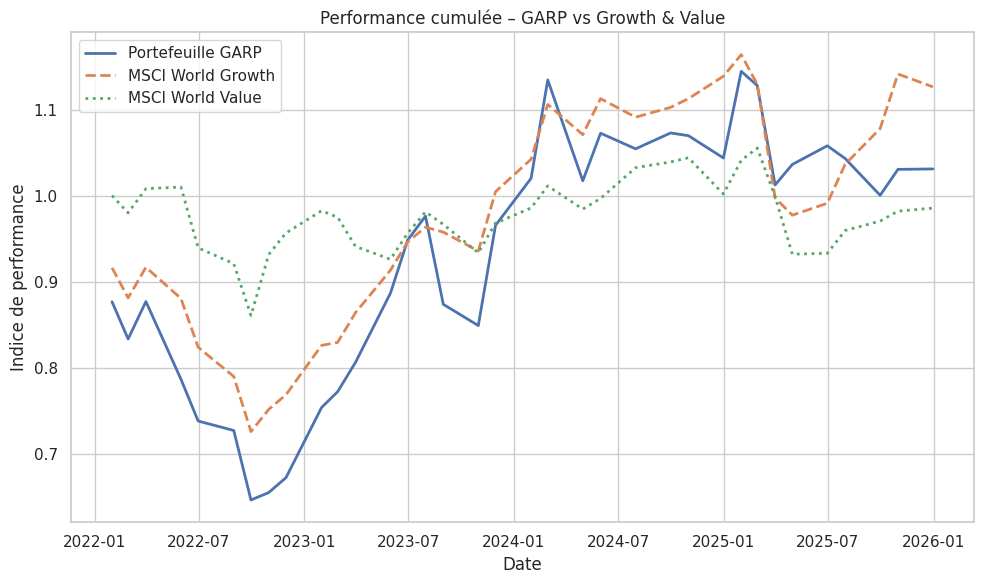

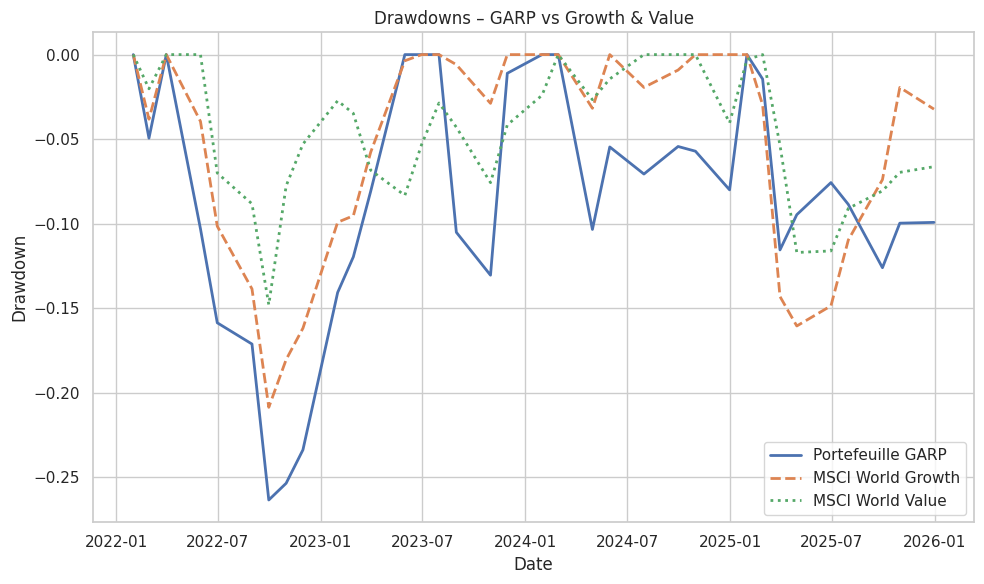

                   Rendement annualisé  Volatilité annualisée  \
GARP                          0.039374               0.242298   
MSCI_World_Growth             0.054305               0.163045   
MSCI_World_Value              0.002132               0.119131   

                   Ratio de Sharpe  Drawdown maximum  
GARP                      0.162501         -0.263587  
MSCI_World_Growth         0.333066         -0.208747  
MSCI_World_Value          0.017894         -0.148055  


In [4]:
# --- Import MSCI World Growth et MSCI World Value ---
msci_growth = pd.read_excel(Path("../data/raw/msci_world_growth_factset.xlsx"))
msci_value = pd.read_excel(Path("../data/raw/msci_world_value_factset.xlsx"))

# Préparation Growth
msci_growth.iloc[:, 0] = pd.to_datetime(msci_growth.iloc[:, 0])
msci_growth.set_index(msci_growth.columns[0], inplace=True)
msci_growth = msci_growth.sort_index()
msci_growth = msci_growth.iloc[:, 0]
msci_growth.name = "MSCI_World_Growth"

# Préparation Value
msci_value.iloc[:, 0] = pd.to_datetime(msci_value.iloc[:, 0])
msci_value.set_index(msci_value.columns[0], inplace=True)
msci_value = msci_value.sort_index()
msci_value = msci_value.iloc[:, 0]
msci_value.name = "MSCI_World_Value"

# --- Calcul des rendements logarithmiques ---
r_growth = np.log(msci_growth / msci_growth.shift(1))
r_value = np.log(msci_value / msci_value.shift(1))

# --- Alignement temporel avec le portefeuille GARP ---
returns_stylistic = pd.concat(
    [garp_portfolio_returns, r_growth, r_value], axis=1, sort=False
).dropna()
returns_stylistic.columns = ["GARP", "MSCI_World_Growth", "MSCI_World_Value"]

# --- Performances cumulées ---
cumulative_stylistic = (1 + returns_stylistic).cumprod()

# Graphique des performances cumulées
plt.figure(figsize=(10, 6))
plt.plot(cumulative_stylistic["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(cumulative_stylistic["MSCI_World_Growth"], label="MSCI World Growth", linestyle="--", linewidth=2)
plt.plot(cumulative_stylistic["MSCI_World_Value"], label="MSCI World Value", linestyle=":", linewidth=2)
plt.title("Performance cumulée – GARP vs Growth & Value")
plt.xlabel("Date")
plt.ylabel("Indice de performance")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "performance_cumulee_garp_growth_value.png")
plt.show()

# --- Drawdowns ---
rolling_max_style = cumulative_stylistic.cummax()
drawdown_style = cumulative_stylistic / rolling_max_style - 1

# Graphique des drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown_style["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(drawdown_style["MSCI_World_Growth"], label="MSCI World Growth", linestyle="--", linewidth=2)
plt.plot(drawdown_style["MSCI_World_Value"], label="MSCI World Value", linestyle=":", linewidth=2)
plt.title("Drawdowns – GARP vs Growth & Value")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "drawdowns_garp_growth_value.png")
plt.show()

# --- Statistiques de performance ---
perf_stats_style = pd.DataFrame(index=["GARP", "MSCI_World_Growth", "MSCI_World_Value"])
perf_stats_style["Rendement annualisé"] = returns_stylistic.mean() * 12
perf_stats_style["Volatilité annualisée"] = returns_stylistic.std() * np.sqrt(12)
perf_stats_style["Ratio de Sharpe"] = perf_stats_style["Rendement annualisé"] / perf_stats_style["Volatilité annualisée"]
perf_stats_style["Drawdown maximum"] = drawdown_style.min()

# Affichage
print(perf_stats_style)

# Sauvegarde des statistiques
perf_stats_style.to_csv(RESULTS_TABLES / "performance_stats_garp_growth_value.csv")


## 4. Décomposition factorielle de la performance

## Objectif

Cette section vise à déterminer si la performance du portefeuille GARP
est expliquée par des expositions factorielles classiques ou si elle
génère un alpha résiduel statistiquement significatif.

Deux modèles sont estimés :

- CAPM
- Fama-French 3 facteurs (Marché, Taille, Valeur)

Hypothèses testées :

H2 — L’alpha du portefeuille GARP est partiellement expliqué par des expositions factorielles.

H3 — Une fraction résiduelle de l’alpha demeure statistiquement significative.

## Interprétation attendue

- Si l’alpha CAPM est significatif, le portefeuille surperforme le marché brut.
- Si l’alpha devient non significatif dans le modèle Fama-French, la performance est expliquée par une exposition factorielle (taille ou value).
- Si l’alpha demeure significatif après contrôle des facteurs, cela suggère une création de valeur propre à la stratégie GARP.

Cette analyse permet de distinguer une simple exposition aux primes de risque connues d’une véritable capacité de sélection de titres.



/tmp/ipykernel_10579/4243851052.py:38: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  data_factor = pd.concat([garp_portfolio_returns, ff], axis=1).dropna()



================ CAPM ================

                            OLS Regression Results                            
Dep. Variable:            GARP_Excess   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4720
Date:                Wed, 11 Feb 2026   Prob (F-statistic):              0.496
Time:                        09:54:44   Log-Likelihood:                 29.212
No. Observations:                  48   AIC:                            -54.42
Df Residuals:                      46   BIC:                            -50.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

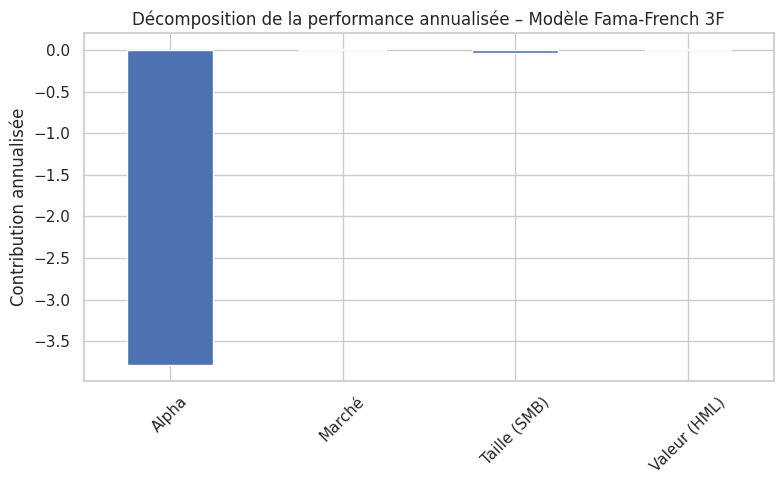

In [5]:
# ===============================
# 4. DECOMPOSITION FACTORIELLE
# ===============================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

# Définition des chemins
DATA_RAW = Path("../data/raw")
RESULTS_TABLES = Path("../results/tables")
RESULTS_FIGURES = Path("../results/figures")

RESULTS_TABLES.mkdir(parents=True, exist_ok=True)
RESULTS_FIGURES.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------
# 4.1 Import des facteurs Fama-French (3 facteurs)
# ---------------------------------------------------

ff = pd.read_excel(DATA_RAW / "fama_french_3factors.xlsx")

# Conversion des dates
ff.iloc[:, 0] = pd.to_datetime(ff.iloc[:, 0])
ff.set_index(ff.columns[0], inplace=True)
ff = ff.sort_index()

# Renommage explicite des colonnes
ff.columns = ["Mkt_RF", "SMB", "HML", "RF"]

# ---------------------------------------------------
# 4.2 Alignement des données
# ---------------------------------------------------

# On concatène portefeuille + facteurs
data_factor = pd.concat([garp_portfolio_returns, ff], axis=1).dropna()

# Rendement excédentaire du portefeuille
data_factor["GARP_Excess"] = data_factor["GARP_Portfolio"] - data_factor["RF"]

# Variable dépendante
y = data_factor["GARP_Excess"]

# Variables explicatives
X_capm = sm.add_constant(data_factor["Mkt_RF"])
X_ff3 = sm.add_constant(data_factor[["Mkt_RF", "SMB", "HML"]])

# ---------------------------------------------------
# 4.3 Estimation du CAPM
# ---------------------------------------------------

model_capm = sm.OLS(y, X_capm).fit()

print("\n================ CAPM ================\n")
print(model_capm.summary())

# ---------------------------------------------------
# 4.4 Estimation Fama-French 3 facteurs
# ---------------------------------------------------

model_ff3 = sm.OLS(y, X_ff3).fit()

print("\n========== FAMA-FRENCH 3 FACTEURS ==========\n")
print(model_ff3.summary())

# ---------------------------------------------------
# 4.5 Tableau de synthèse des résultats
# ---------------------------------------------------

results_factor = pd.DataFrame({
    "Alpha (mensuel)": [
        model_capm.params["const"],
        model_ff3.params["const"]
    ],
    "Alpha (annualisé)": [
        model_capm.params["const"] * 12,
        model_ff3.params["const"] * 12
    ],
    "Beta_Market": [
        model_capm.params["Mkt_RF"],
        model_ff3.params["Mkt_RF"]
    ],
    "Beta_SMB": [
        np.nan,
        model_ff3.params["SMB"]
    ],
    "Beta_HML": [
        np.nan,
        model_ff3.params["HML"]
    ],
    "R²": [
        model_capm.rsquared,
        model_ff3.rsquared
    ],
    "p-value Alpha": [
        model_capm.pvalues["const"],
        model_ff3.pvalues["const"]
    ]
}, index=["CAPM", "Fama-French 3F"])

print("\n======= SYNTHESE DES RESULTATS =======\n")
print(results_factor)

# Sauvegarde
results_factor.to_csv(RESULTS_TABLES / "decomposition_factorielle_garp.csv")

# ---------------------------------------------------
# 4.6 Décomposition économique de la performance
# ---------------------------------------------------

mean_factors = data_factor[["Mkt_RF", "SMB", "HML"]].mean()

beta_m = model_ff3.params["Mkt_RF"]
beta_s = model_ff3.params["SMB"]
beta_v = model_ff3.params["HML"]
alpha = model_ff3.params["const"]

contrib = pd.Series({
    "Alpha": alpha * 12,
    "Marché": beta_m * mean_factors["Mkt_RF"] * 12,
    "Taille (SMB)": beta_s * mean_factors["SMB"] * 12,
    "Valeur (HML)": beta_v * mean_factors["HML"] * 12
})

print("\n======= CONTRIBUTION FACTORIELLE ANNUALISEE =======\n")
print(contrib)

contrib.to_csv(RESULTS_TABLES / "contribution_factorielle_garp.csv")

# ---------------------------------------------------
# 4.7 Visualisation des contributions
# ---------------------------------------------------

plt.figure(figsize=(8,5))
contrib.plot(kind="bar")
plt.title("Décomposition de la performance annualisée – Modèle Fama-French 3F")
plt.ylabel("Contribution annualisée")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "contribution_factorielle_garp.png")
plt.show()


# 5. Analyse de la persistance du couple rendement–risque

## Objectif

Cette section vise à analyser la stabilité temporelle de la performance
du portefeuille GARP.

L’objectif est de déterminer si :

- le rendement ajusté du risque est stable dans le temps ;
- l’alpha estimé précédemment est persistant ;
- la stratégie présente une robustesse intertemporelle.

Deux approches sont utilisées :

1. Analyse rolling (fenêtres mobiles) :
   - Sharpe ratio rolling
   - Alpha rolling (modèle Fama-French)

2. Analyse par sous-périodes :
   - Comparaison des performances sur deux sous-échantillons

Hypothèse testée :

H4 — Le couple rendement–risque du portefeuille GARP est persistant dans le temps.


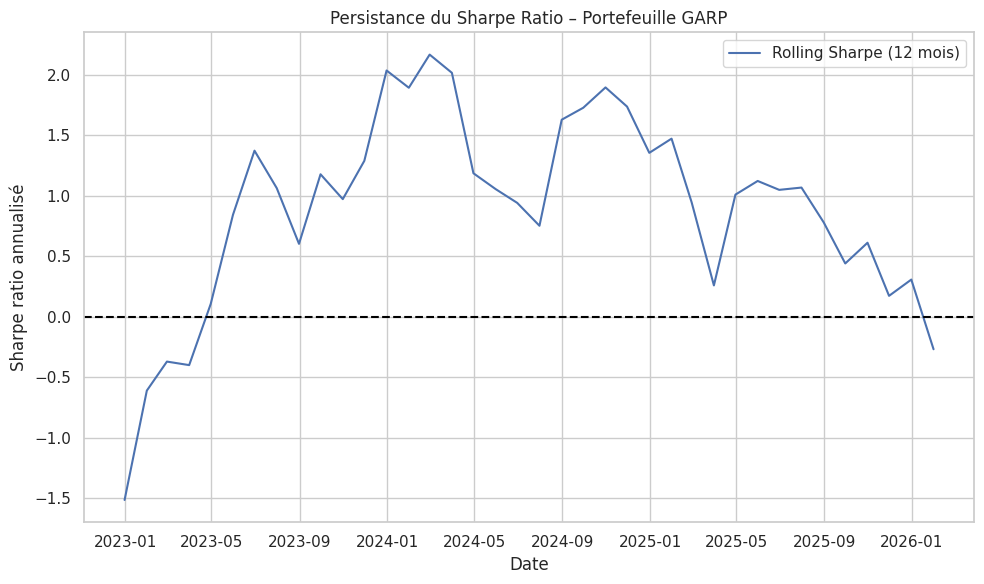

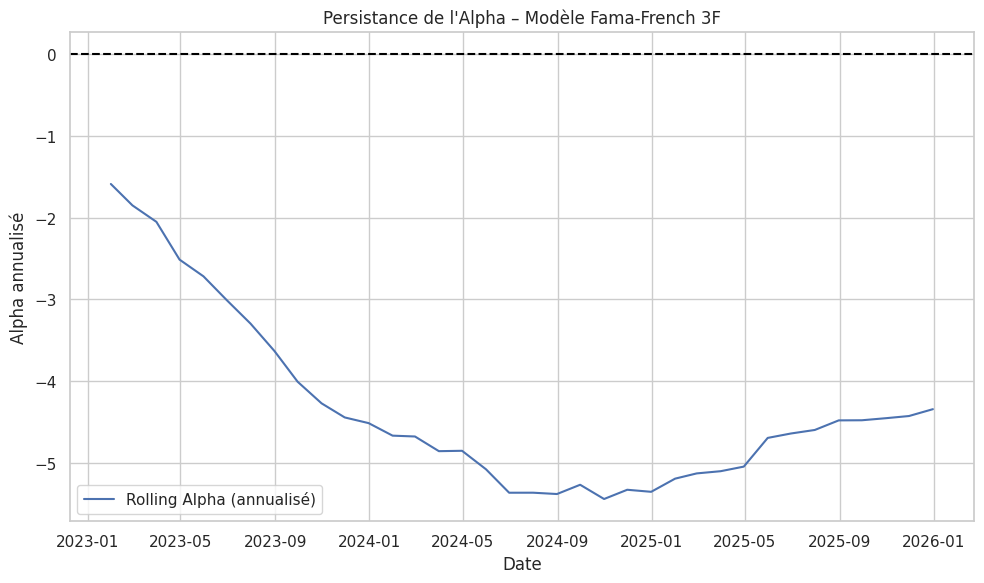


======= ANALYSE PAR SOUS-PERIODES =======

                       Sous-période 1  Sous-période 2
Rendement annualisé          0.017792        0.150381
Volatilité annualisée        0.286344        0.183695
Sharpe                       0.062134        0.818644


In [6]:
# ===========================================
# 5. PERSISTANCE DU COUPLE RENDEMENT-RISQUE
# ===========================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_TABLES = Path("../results/tables")
RESULTS_FIGURES = Path("../results/figures")

# -------------------------------------------
# 5.1 Rolling Sharpe Ratio (12 mois)
# -------------------------------------------

window = 12  # fenêtre de 12 mois

rolling_mean = garp_portfolio_returns.rolling(window).mean()
rolling_std = garp_portfolio_returns.rolling(window).std()

rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(12)

plt.figure(figsize=(10,6))
plt.plot(rolling_sharpe, label="Rolling Sharpe (12 mois)")
plt.axhline(0, color="black", linestyle="--")
plt.title("Persistance du Sharpe Ratio – Portefeuille GARP")
plt.xlabel("Date")
plt.ylabel("Sharpe ratio annualisé")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "rolling_sharpe_garp.png")
plt.show()

rolling_sharpe.to_csv(RESULTS_TABLES / "rolling_sharpe_garp.csv")

# -------------------------------------------
# 5.2 Rolling Alpha (Fama-French 3F)
# -------------------------------------------

rolling_alpha = []

dates = data_factor.index

for i in range(window, len(data_factor)):
    
    sub_data = data_factor.iloc[i-window:i]
    
    y_sub = sub_data["GARP_Excess"]
    X_sub = sm.add_constant(sub_data[["Mkt_RF", "SMB", "HML"]])
    
    model_sub = sm.OLS(y_sub, X_sub).fit()
    
    rolling_alpha.append(model_sub.params["const"] * 12)

rolling_alpha_series = pd.Series(
    rolling_alpha,
    index=dates[window:]
)

plt.figure(figsize=(10,6))
plt.plot(rolling_alpha_series, label="Rolling Alpha (annualisé)")
plt.axhline(0, color="black", linestyle="--")
plt.title("Persistance de l'Alpha – Modèle Fama-French 3F")
plt.xlabel("Date")
plt.ylabel("Alpha annualisé")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "rolling_alpha_garp.png")
plt.show()

rolling_alpha_series.to_csv(RESULTS_TABLES / "rolling_alpha_garp.csv")

# -------------------------------------------
# 5.3 Analyse par sous-périodes
# -------------------------------------------

midpoint = len(garp_portfolio_returns) // 2

sub1 = garp_portfolio_returns.iloc[:midpoint]
sub2 = garp_portfolio_returns.iloc[midpoint:]

def performance_stats(series):
    return pd.Series({
        "Rendement annualisé": series.mean() * 12,
        "Volatilité annualisée": series.std() * np.sqrt(12),
        "Sharpe": (series.mean() * 12) / (series.std() * np.sqrt(12))
    })

subperiod_stats = pd.DataFrame({
    "Sous-période 1": performance_stats(sub1),
    "Sous-période 2": performance_stats(sub2)
})

print("\n======= ANALYSE PAR SOUS-PERIODES =======\n")
print(subperiod_stats)

subperiod_stats.to_csv(RESULTS_TABLES / "persistance_sous_periodes_garp.csv")


# 6. Analyse de robustesse

## Objectif

Cette section vise à vérifier la solidité des résultats obtenus pour le portefeuille GARP
face à :

1. Des benchmarks alternatifs : FTSE All-World
2. Différents découpages temporels : rolling windows, sous-périodes
3. Comparaisons de performances cumulées et ratios Sharpe

L’idée est de tester si la surperformance et l’alpha résiduel sont dépendants
du choix du benchmark ou du découpage temporel.

Hypothèses testées :

- H1 & H4 : la performance ajustée du risque et la persistance du couple rendement–risque
  restent robustes face à un benchmark alternatif et à différents horizons temporels.


/tmp/ipykernel_10579/238055033.py:30: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  returns_robust = pd.concat([garp_portfolio_returns, r_ftse_aw], axis=1).dropna()


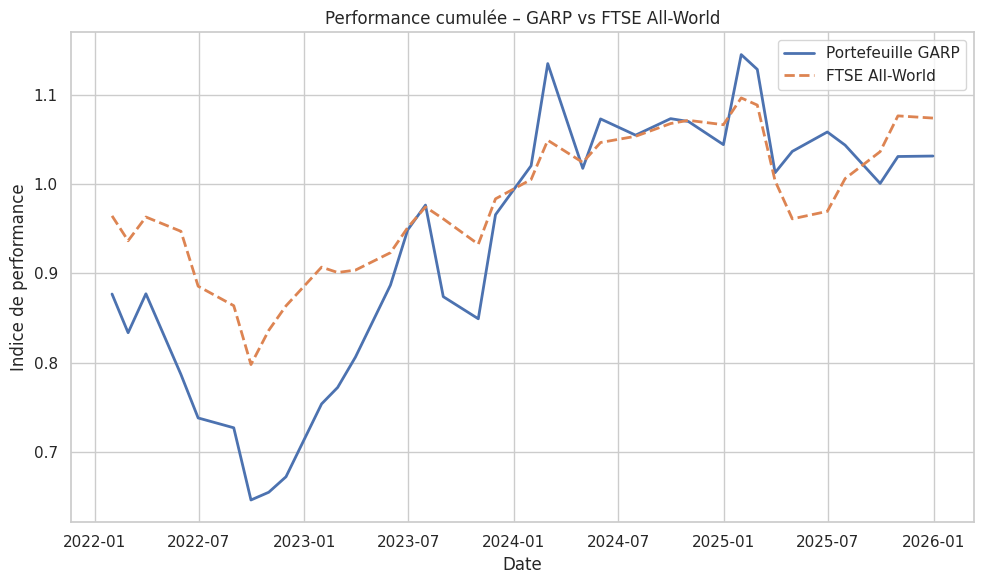

                Rendement annualisé  Volatilité annualisée  Ratio de Sharpe
GARP                       0.039374               0.242298         0.162501
FTSE_All_World             0.031879               0.121688         0.261974


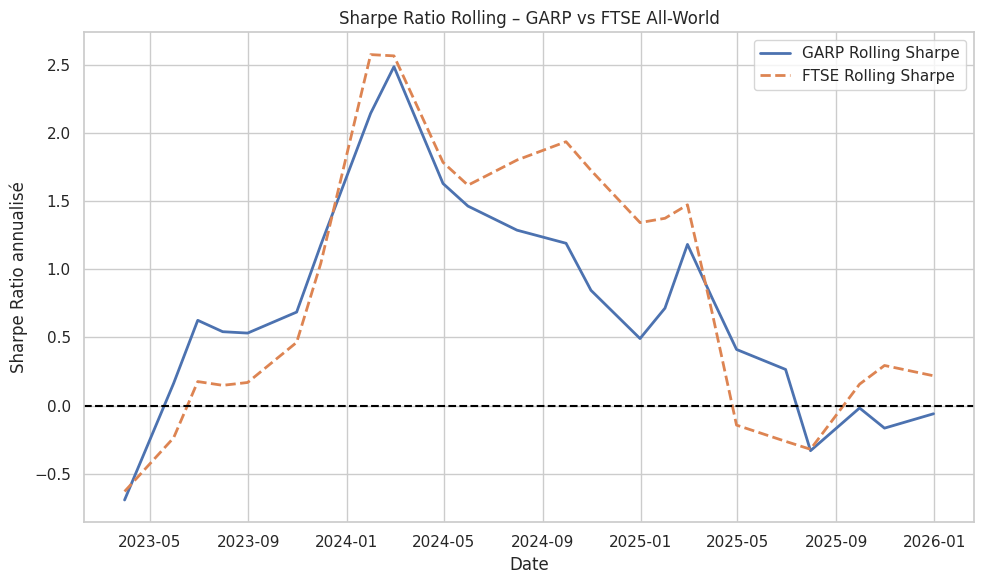


======= ANALYSE DE ROBUSTESSE PAR SOUS-PERIODES =======

                Rendement annualisé (Sous-période 1)  \
GARP                                       -0.081714   
FTSE_All_World                             -0.040896   

                Volatilité annualisée (Sous-période 1)  \
GARP                                          0.263360   
FTSE_All_World                                0.130411   

                Sharpe (Sous-période 1)  Rendement annualisé (Sous-période 2)  \
GARP                          -0.310275                              0.153734   
FTSE_All_World                -0.313594                              0.100611   

                Volatilité annualisée (Sous-période 2)  \
GARP                                          0.223075   
FTSE_All_World                                0.112920   

                Sharpe (Sous-période 2)  
GARP                           0.689159  
FTSE_All_World                 0.890998  


In [7]:
# ===========================================
# 6. ANALYSE DE ROBUSTESSE
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_FIGURES = Path("../results/figures")
RESULTS_TABLES = Path("../results/tables")

# -------------------------------------------
# 6.1 Import FTSE All-World (raw data)
# -------------------------------------------

ftse_aw = pd.read_excel(Path("../data/raw/ftse_all_world_factset.xlsx"))

# Conversion de la première colonne en datetime
ftse_aw.iloc[:,0] = pd.to_datetime(ftse_aw.iloc[:,0])
ftse_aw.set_index(ftse_aw.columns[0], inplace=True)
ftse_aw = ftse_aw.sort_index()
ftse_aw = ftse_aw.iloc[:,0]
ftse_aw.name = "FTSE_All_World"

# Rendements logarithmiques mensuels
r_ftse_aw = np.log(ftse_aw / ftse_aw.shift(1))

# Alignement temporel avec GARP
returns_robust = pd.concat([garp_portfolio_returns, r_ftse_aw], axis=1).dropna()
returns_robust.columns = ["GARP", "FTSE_All_World"]

# -------------------------------------------
# 6.2 Performance cumulée
# -------------------------------------------

cumulative_robust = (1 + returns_robust).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cumulative_robust["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(cumulative_robust["FTSE_All_World"], label="FTSE All-World", linestyle="--", linewidth=2)
plt.title("Performance cumulée – GARP vs FTSE All-World")
plt.xlabel("Date")
plt.ylabel("Indice de performance")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "performance_cumulee_garp_vs_ftse.png")
plt.show()

# -------------------------------------------
# 6.3 Statistiques annuelles et ratio Sharpe
# -------------------------------------------

perf_stats_robust = pd.DataFrame(index=["GARP", "FTSE_All_World"])
perf_stats_robust["Rendement annualisé"] = returns_robust.mean() * 12
perf_stats_robust["Volatilité annualisée"] = returns_robust.std() * np.sqrt(12)
perf_stats_robust["Ratio de Sharpe"] = perf_stats_robust["Rendement annualisé"] / perf_stats_robust["Volatilité annualisée"]

# Affichage et sauvegarde
print(perf_stats_robust)
perf_stats_robust.to_csv(RESULTS_TABLES / "performance_stats_garp_ftse.csv")

# -------------------------------------------
# 6.4 Analyse par rolling window
# -------------------------------------------

window = 12  # 12 mois

rolling_sharpe_robust = (returns_robust.rolling(window).mean() / returns_robust.rolling(window).std()) * np.sqrt(12)

plt.figure(figsize=(10,6))
plt.plot(rolling_sharpe_robust["GARP"], label="GARP Rolling Sharpe", linewidth=2)
plt.plot(rolling_sharpe_robust["FTSE_All_World"], label="FTSE Rolling Sharpe", linestyle="--", linewidth=2)
plt.axhline(0, color="black", linestyle="--")
plt.title("Sharpe Ratio Rolling – GARP vs FTSE All-World")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio annualisé")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "rolling_sharpe_garp_vs_ftse.png")
plt.show()

rolling_sharpe_robust.to_csv(RESULTS_TABLES / "rolling_sharpe_garp_vs_ftse.csv")

# -------------------------------------------
# 6.5 Analyse par sous-périodes
# -------------------------------------------

midpoint = len(returns_robust) // 2
sub1 = returns_robust.iloc[:midpoint]
sub2 = returns_robust.iloc[midpoint:]

def subperiod_perf(df):
    return pd.DataFrame({
        "Rendement annualisé": df.mean() * 12,
        "Volatilité annualisée": df.std() * np.sqrt(12),
        "Sharpe": (df.mean() * 12) / (df.std() * np.sqrt(12))
    })

subperiod_stats_robust = pd.concat([
    subperiod_perf(sub1).rename(columns=lambda x: x + " (Sous-période 1)"),
    subperiod_perf(sub2).rename(columns=lambda x: x + " (Sous-période 2)")
], axis=1)

print("\n======= ANALYSE DE ROBUSTESSE PAR SOUS-PERIODES =======\n")
print(subperiod_stats_robust)

subperiod_stats_robust.to_csv(RESULTS_TABLES / "robustesse_sous_periodes_garp_ftse.csv")
